In [3]:
import sys
sys.path.insert(0, "/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages")
sys.path.append('/afs/ir/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/util')
print sys.path
import lasagne
print lasagne.__version__

from data_utils import get_CIFAR10_data
import os
os.environ['THEANO_FLAGS'] = 'floatX=float32'
%load_ext autoreload 
%autoreload 2

['/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages', '/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages', '/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages', '', '/usr/local/lib/python2.7/site-packages', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/c

In [4]:
# Autoencoder

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
from theano import pp
import time

import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, InverseLayer

from lasagne.utils import floatX
from lasagne.updates import adam
from lasagne.nonlinearities import softmax



In [65]:
from data_utils import get_CIFAR10_data

print os.environ['THEANO_FLAGS']
data = np.random.random((1024, 128)).astype(np.float32)

img_data = get_CIFAR10_data()


floatX=float32
ROOT:  ../datasets/cifar-10-batches-py/


In [66]:
# for k, v in img_data.iteritems():
#   print '%s: ' % k, v.shape

X_val = img_data['X_val']
X_val = np.array( X_val.reshape((1000, -1)))
print X_val.shape
data = X_val
y = data 

(1000, 3072)


In [69]:
# # Make lasagne layers

# input_var = T.matrix('inputs')
# target_var = T.matrix('targets')

# net = {}
# net['input'] = InputLayer ((None, 128), input_var=input_var)
# net['h1'] = DenseLayer(net['input'], num_units=64, nonlinearity=T.nnet.relu,
#                                        W=lasagne.init.HeNormal(gain=1.0) )
# net['h2'] = DenseLayer(net['h1'], num_units=32, nonlinearity=lasagne.nonlinearities.tanh, 
#                                        W=lasagne.init.HeNormal(gain=1.0) )

# net['h2_inv'] = InverseLayer(net['h2'], net['h2'])
# net['h1_inv'] = InverseLayer(net['h2_inv'], net['h1'])

# # l1 = InputLayer((None, 784))
# # l2 = DenseLayer(l1, num_units=500, nonlinearity=lasagne.nonlinearities.rectify, )
# # l3 = InverseLayer(l2, l2)

hidden_sizes=[1536, 768, 384, 192]
input_sz=3072

input_var = T.matrix('inputs')
target_var = T.matrix('targets')

names = ['h{0}'.format(i) for i in xrange(len(hidden_sizes))]
inv_names = ['h{0}_inv'.format(i) for i in xrange(len(hidden_sizes))][::-1]
net = {}

print names, inv_names

net['input'] = InputLayer ((None, input_sz), input_var=input_var)

prev = net['input']
for i, name in enumerate(names):
    net[name] = DenseLayer(prev, num_units=hidden_sizes[i], 
                                 nonlinearity=T.nnet.relu,
                                 W=lasagne.init.HeNormal(gain='relu') )
    prev = net[name]


# Build reverse layers  
for j, name in enumerate(inv_names):
    print names[-j-1]
    net[name] = InverseLayer(prev, net[names[-j-1]])
    prev = net[name]



['h0', 'h1', 'h2', 'h3'] ['h3_inv', 'h2_inv', 'h1_inv', 'h0_inv']
h3
h2
h1
h0


In [70]:
params = lasagne.layers.get_all_params(net['h0_inv'], trainable=True)
init_weights = lasagne.layers.get_all_param_values(net['h0_inv'])
out = lasagne.layers.get_output(net['h0_inv'], deterministic=True)

loss = lasagne.objectives.squared_error(out, target_var)
adam_update = adam (loss.mean(), params)

train_function = theano.function([input_var, target_var], loss, updates=adam_update)

In [9]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """
    Get minibatch for data.
    :param inputs:
    :param targets:
    :param batchsize:
    :param shuffle:
    :return:
    """
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [133]:
def train(x=data, y=data, num_epochs=20):
    
    lasagne.layers.set_all_param_values (net['h0_inv'], init_weights)
    batch_size = 99
    print x.dtype
    print y.dtype
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0.0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(x, y, batch_size, shuffle=True):
            inputs, targets = batch
            train_err += train_function(inputs, targets)
            train_batches += 1
        
        print 'epoch {0} done in time {1}; Loss = {2}'.format(epoch, time.time() - start_time, 
                                                              np.sum(train_err)/(x.shape[0] * 3072.))
    
    

In [134]:
train(data, y, num_epochs=20)

float64
float64
Starting training...
epoch 0 done in time 3.28649187088; Loss = 3601.27220836


KeyboardInterrupt: 

In [73]:
param_values = lasagne.layers.get_all_param_values(net['h0_inv'])
for val in param_values:
    print val.shape

(3072, 1536)
(1536,)
(1536, 768)
(768,)
(768, 384)
(384,)
(384, 192)
(192,)


In [92]:
compressed = np.array(lasagne.layers.get_output(net['h0_inv'], data, deterministic=True).eval())


In [93]:
print compressed.shape

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

(1000, 3072)


In [94]:
%matplotlib inline
test_img = compressed

test_img = test_img.reshape((1000, 3, 32, 32))
test_img = np.transpose(test_img, (0, 2, 3, 1))

normed_data = data.reshape((1000, 3, 32, 32))
normed_data = np.transpose(normed_data, (0, 2, 3, 1))
print normed_data.shape
print test_img.shape




(1000, 32, 32, 3)
(1000, 32, 32, 3)


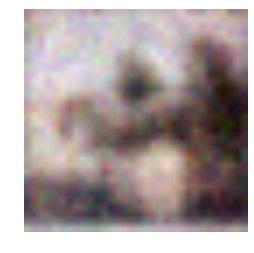

In [131]:
i = np.random.randint(1000)
imshow_noax(test_img[i])

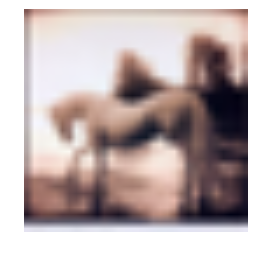

In [132]:
imshow_noax(normed_data[i])